# ACA centroiding/ Dynamic Background/ Real Data Example#

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import numpy.ma as ma
import collections
from Ska.Matplotlib import plot_cxctime
from copy import deepcopy
from importlib import reload
from astropy.io import ascii

In [2]:
# local imports:
import sys
sys.path.append("../py")
from bgd_classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### HRC data ###

Use real data (HRC, large dither amplitude of 20 arcsec) to compute centroids using various algorithm <code>(StandardBgd, DynamBgd_Median, DynamBgd_SigmaClip)</code>

__Results__

* Centroiding improves with <code>DynamBgd_Median, DynamBgd_SigmaClip</code> as compared to <code>StandradBgd</code> algorithm.


* <code>DynamBgd_Median, DynamBgd_SigmaClip</code> perform at the same level, independently on the number of samples.


* Centroiding improves for both <code>DynamBgd_Median</code> and <code>DynamBgd_SigmaClip</code> while the number of samples increases.

In [4]:
std_results = """
name                 std_1000  std_25   std_5
StandardBgd          0.56      0.56     0.56
DynamBgd_Median      0.31      0.35     0.37
DynamBgd_SigmaClip   0.31      0.34     0.37
"""
std_results = ascii.read(std_results)
print(std_results)

       name        std_1000 std_25 std_5
------------------ -------- ------ -----
       StandardBgd     0.56   0.56  0.56
   DynamBgd_Median     0.31   0.35  0.37
DynamBgd_SigmaClip     0.31   0.34  0.37


__Computations__

In [5]:
# 50804, ACIS, stars in all slots tracked, star in slot 7 faint, all other stars bright
#obsid = 50804
#slots = [2, 4, 7]

# 8912, HRC, stars in all slots tracked, star in slot 3 faint
obsid = 8912
img_size = 6 # pixels
dwell = events.dwells.filter(obsid=obsid)[0]

In [50]:
msids = ["aoacfct{}".format(slot) for slot in range(8)] + \
        ["aoacmag{}".format(slot) for slot in range(8)]
dat = fetch.MSIDset(msids, start=dwell.start, stop=dwell.stop)

print('TRAK:')
print([dat[msid].vals.tolist().count('TRAK') for msid in msids[:8]])
print('RACQ:')
print([dat[msid].vals.tolist().count('RACQ') for msid in msids[:8]])
print('SRCH:')
print([dat[msid].vals.tolist().count('SRCH') for msid in msids[:8]])
print('MAG:')
print([np.median(dat[msid].vals) for msid in msids[8:]])

TRAK:
[7983, 7983, 7983, 7983, 7983, 7983, 7983, 7983]
RACQ:
[0, 0, 0, 0, 0, 0, 0, 0]
SRCH:
[0, 0, 0, 0, 0, 0, 0, 0]
MAG:
[6.9375, 7.0, 7.0625, 10.4375, 7.625, 8.875, 9.8125, 7.625]


In [7]:
def do_computations(slots, dwell, img_size, nframes, ndeque, init_kwargs):
    rows_all = []
    for slot in slots:
        slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        for i, Bgd_Class in enumerate([StandardBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
            bgd_object = Bgd_Class(**init_kwargs[i]) 
            rows = cntr.centroids(slot, slot_data, img_size, bgd_object, nframes=nframes)
            for row in rows:
                row['mag'] = np.median(dat["aoacmag{}".format(slot)].vals)
                row['bgd_type'] = bgd_object.__class__.__name__
                if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                    row['ndeque'] = ndeque
                else:
                    row['ndeque'] = None
                rows_all.append(row)        
    t = Table(rows_all)
    return t

In [8]:
slots = [3, 4] # Faint 10.4 mag, and bright 7.6 mag stars
bgdavg = None
nframes = 1000

__Large__ number of samples

In [9]:
ndeque = 1000
init_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                   {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

In [10]:
t_data_1000 = do_computations(slots, dwell, img_size, nframes, ndeque, init_kwargs)

Slot = 3
Slot = 3
Slot = 3
Slot = 4
Slot = 4
Slot = 4


In [13]:
ok = t_data_1000['bgd_type'] == 'StandardBgd'
print((t_data_1000[ok]['time'][1] - t_data_1000[ok]['time'][0])[:5]) # bright - faint

[ 0.  0.  0.  0.  0.]


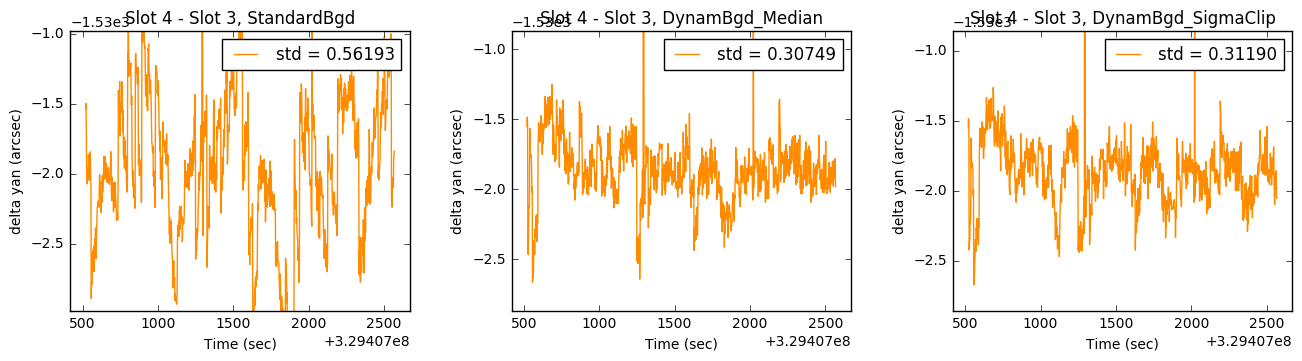

In [14]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
mplt.plot_d_ang(3, 4, key, dt, t_data_1000)

__Medium__ number of samples

In [15]:
ndeque = 25
init_kwargs[1]['ndeque'] = ndeque
init_kwargs[2]['ndeque'] = ndeque

In [16]:
t_data_25 = do_computations(slots, dwell, img_size, nframes, ndeque, init_kwargs)

Slot = 3
Slot = 3
Slot = 3
Slot = 4
Slot = 4
Slot = 4


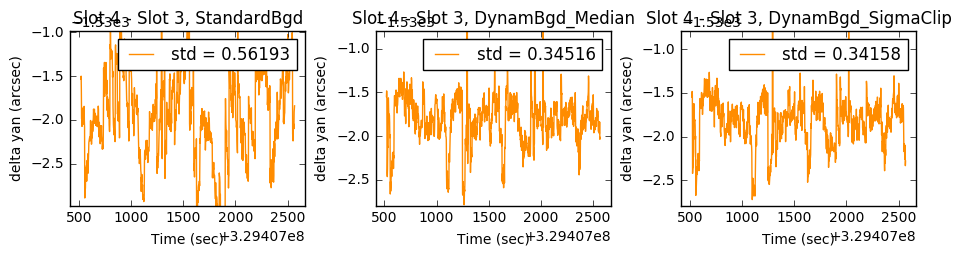

In [54]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
mplt.plot_d_ang(3, 4, key, dt, t_data_25)

__Small__ number of samples

In [18]:
ndeque = 5
init_kwargs[1]['ndeque'] = ndeque
init_kwargs[2]['ndeque'] = ndeque

In [19]:
t_data_5 = do_computations(slots, dwell, img_size, nframes, ndeque, init_kwargs)

Slot = 3
Slot = 3
Slot = 3
Slot = 4
Slot = 4
Slot = 4


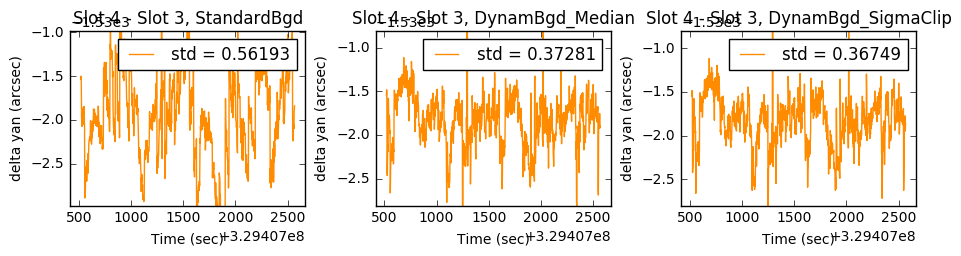

In [55]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
mplt.plot_d_ang(3, 4, key, dt, t_data_5)

### Plot centroids###


Large number of samples, ndeque = 1000


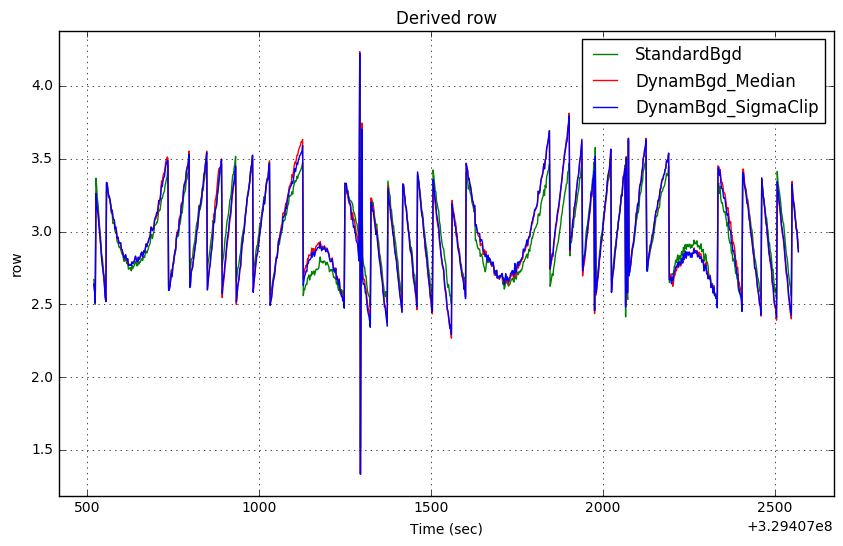

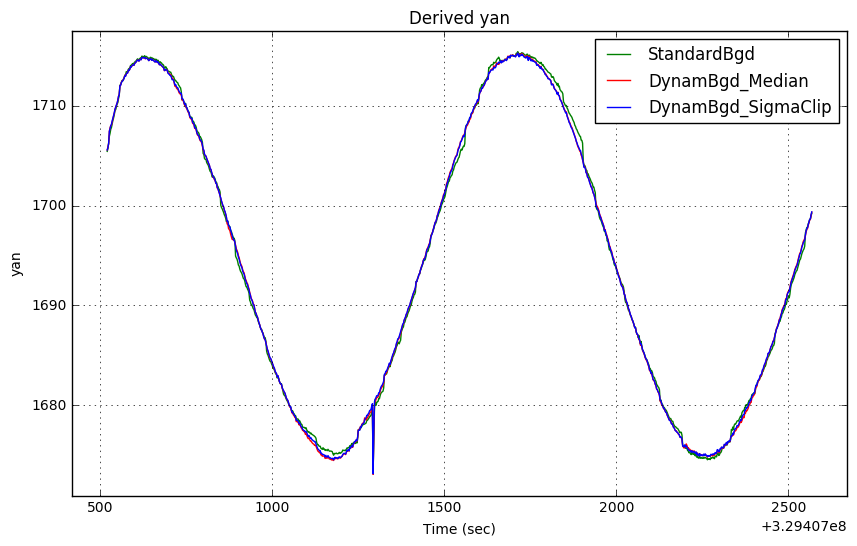

In [24]:
slot = slots[0] # 3, Faint star
mplt.plot_coords(slot, t_data_1000, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_data_1000, 'yan') # computed 'yan' coordinate
print()
print("Large number of samples, ndeque = {}".format(1000))


Small number of samples, ndeque = 5


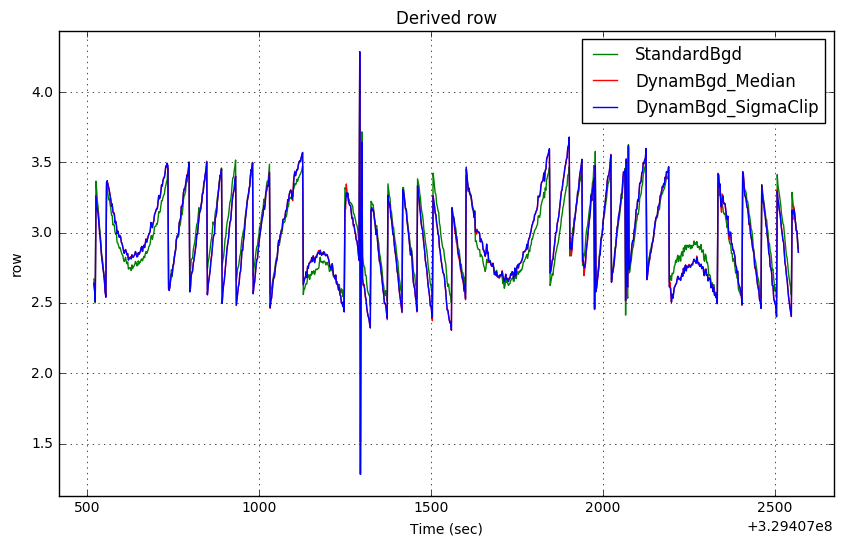

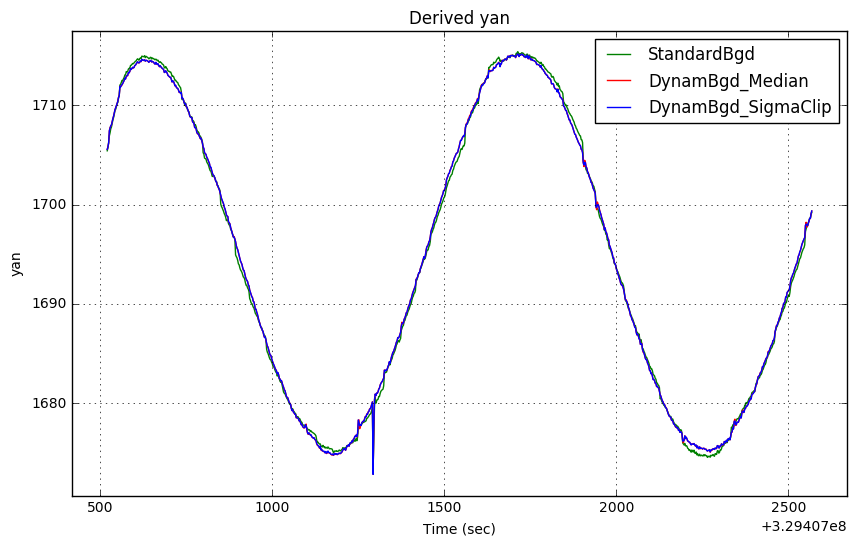

In [46]:
slot = slots[0] # 3, Faint star
mplt.plot_coords(slot, t_data_5, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_data_5, 'yan') # computed 'yan' coordinate
print()
print("Small number of samples, ndeque = {}".format(5))

__Plot the derived background images__

* <span style="color:blue">Blue patch</span> - region eventually covered due to the dither
* <span style="color:red">6x6 patches</span> - regions corresponding to a current frame

In [60]:
reload(mplt)

<module 'myplot' from '../py/myplot.py'>

In [26]:
slot = 3 # Faint star

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgd images from 140 to 150
Method: DynamBgd_Median, ndeque = 5


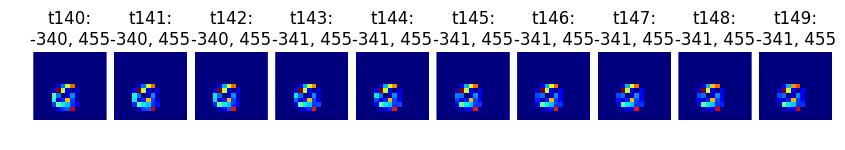

In [61]:
mplt.plot_bgd_images(t_data_5, slot=slot, n_start=140, n_stop=150, img_size=img_size, method='DynamBgd_Median')

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 140 to 150
Method: DynamBgd_Median, ndeque = 5


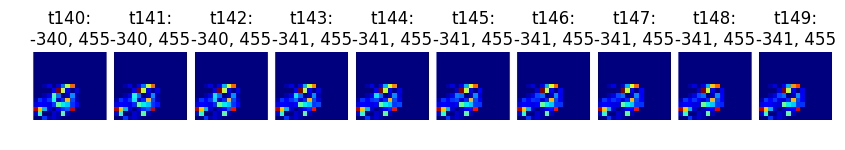

In [62]:
mplt.plot_bgd_patches(t_data_5, slot=slot, n_start=140, n_stop=150, img_size=img_size, method='DynamBgd_Median')

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 990 to 1000
Method: DynamBgd_Median, ndeque = 5


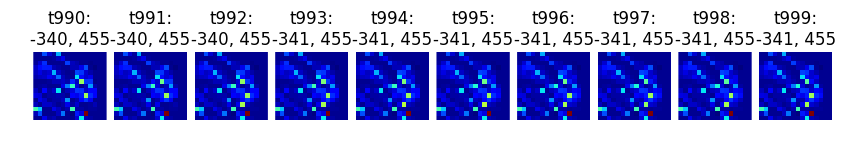

In [63]:
n_start = nframes - 10
mplt.plot_bgd_patches(t_data_5, slot=slot, n_start=n_start, n_stop=nframes,
                      img_size=img_size, method='DynamBgd_Median')

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 990 to 1000
Method: DynamBgd_SigmaClip, ndeque = 1000


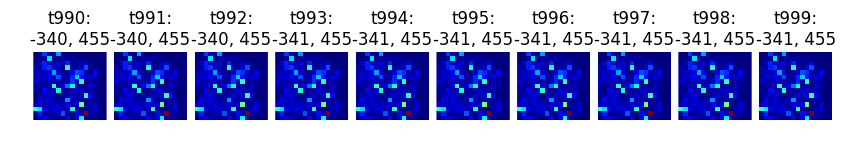

In [65]:
n_start = nframes - 10
mplt.plot_bgd_patches(t_data_1000, slot=slot, n_start=n_start, n_stop=nframes,
                      img_size=img_size, method='DynamBgd_SigmaClip')

In [42]:
ok = t_data_1000['bgd_type'] == 'DynamBgd_Median'
ok1 = t_data_1000['slot'] == slot
lens = []
for key, val in t_data_1000[ok * ok1]['deque_dict'][0][-1].items():
    lens.append(len(val))
    
print("Min deque length = {}, Max deque length = {}".format(np.min(lens), np.max(lens)))

Min deque length = 1, Max deque length = 259
